Make sure you download the 2016 Household LSMS survey data for Malawi, Ethiopia, and Nigeria from https://microdata.worldbank.org/index.php/catalog/lsms and put it in `../data/countries/`. Malawi's data should be named `malawi_2016/LSMS`, Ethiopia's should be named `ethiopia_2015/LSMS`, and Nigeria's should be named `nigeria_2015/LSMS`. Nightlights data should be downloaded from https://ngdc.noaa.gov/eog/viirs/download_dnb_composites.html using the annual composite from 2015 in tile 2 and tile 5.

In [3]:
import pandas as pd
import numpy as np
import os
import geoio
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
BASE_DIR = '..'

COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')

In [5]:
import sys
sys.path.append(BASE_DIR)
from utils import create_space

In [8]:
'''
The goal of each of these functions is to output a dataframe with the following columns:
country, cluster_lat, cluster_lon, cons_pc

Each row should represent one cluster by combining the household data
'''

def process_ethiopia():
    lsms_dir = os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'LSMS')
    consumption_file = 'Consumption Aggregate/cons_agg_w3.csv'
    consumption_pc_col = 'total_cons_ann' # per capita
    hhsize_col = 'hh_size' # people in household

    harvest_file = 'Post-Harvest/sect11_ph_w3.csv'
    harvest_value_col = 'ph_s11q04'
    
    geovariables_file = 'Geovariables/ETH_HouseholdGeovars_y3.csv'
    lat_col = 'lat_dd_mod'
    lon_col = 'lon_dd_mod'

    # purchasing power parity for ethiopia in 2015 (https://data.worldbank.org/indicator/PA.NUS.PRVT.PP?locations=ET)
    ppp = 7.882
    
    for file in [consumption_file, geovariables_file]:
        assert os.path.isfile(os.path.join(lsms_dir, file)), print(f'Could not find {file}')
    
    df_c = pd.read_csv(os.path.join(lsms_dir, consumption_file))
    df_c['cons_ph'] = df_c[consumption_pc_col] * df_c[hhsize_col]
    df_c['pph'] = df_c[hhsize_col]
    df_c['cons_ph'] = df_c['cons_ph'] / ppp / 365
    df_c = df_c[['household_id2', 'cons_ph', 'pph']]
    
    df_h = pd.read_csv(os.path.join(lsms_dir, harvest_file))
    df_h['total_hv'] = df_h[harvest_value_col]
    df_h = df_h[['household_id2', 'total_hv']]
    
    df = pd.merge(df_c, df_h, on='household_id2')

    df_geo = pd.read_csv(os.path.join(lsms_dir, geovariables_file))
    df_cords = df_geo[['household_id2', lat_col, lon_col]]
    df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)
    df_combined = pd.merge(df, df_cords, on='household_id2')
    df_combined.drop(['household_id2'], axis=1, inplace=True)
    df_combined.dropna(inplace=True) # can't use na values
    
    df_clusters = df_combined.groupby(['cluster_lat', 'cluster_lon']).sum().reset_index()
    df_clusters['cons_pc'] = df_clusters['cons_ph'] / df_clusters['pph'] # divides total cluster income by people
    df_clusters['country'] = 'eth'
    return df_clusters[['country', 'cluster_lat', 'cluster_lon', 'cons_pc', 'total_hv']]

In [9]:
df_eth = process_ethiopia()

/root/miniconda3/envs/omtest/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
df_eth.shape

(233, 5)

In [37]:
df_eth.head()

,country,cluster_lat,cluster_lon,cons_pc,nightlights
0,eth,3.455701,39.515994,14.854634,0.0
1,eth,3.549937,39.184234,14.312022,0.0
2,eth,3.864243,39.101366,12.470145,0.0
3,eth,3.982931,38.491368,8.336539,0.0
4,eth,4.048194,41.930928,4.762526,0.0


In [11]:
df_eth['total_hv'].mean()

11313.175965665236

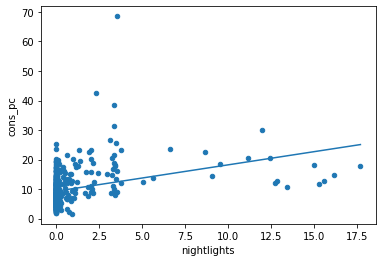

In [41]:
df_eth.plot.scatter(x="nightlights", y="cons_pc")
x = df_eth['nightlights']
y = df_eth['cons_pc']
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

In [31]:
df_mw.corr()

,cluster_lat,cluster_lon,cons_pc,nightlights
cluster_lat,1.000000,-0.702793,-0.026563,-0.083273
cluster_lon,-0.702793,1.000000,-0.002947,-0.033367
cons_pc,-0.026563,-0.002947,1.000000,0.384939
nightlights,-0.083273,-0.033367,0.384939,1.000000


In [71]:
df_eth.corr()

,cluster_lat,cluster_lon,cons_pc,nightlights
cluster_lat,1.000000,-0.393814,-0.159620,0.276469
cluster_lon,-0.393814,1.000000,0.227406,-0.206171
cons_pc,-0.159620,0.227406,1.000000,-0.144788
nightlights,0.276469,-0.206171,-0.144788,1.000000


In [72]:
df_ng.corr()

,cluster_lat,cluster_lon,cons_pc,nightlights
cluster_lat,1.000000,0.220615,0.279542,-0.374902
cluster_lon,0.220615,1.000000,0.213043,-0.038491
cons_pc,0.279542,0.213043,1.000000,0.067457
nightlights,-0.374902,-0.038491,0.067457,1.000000


In [73]:
for country in ['malawi_2016', 'ethiopia_2015', 'nigeria_2015']:
    os.makedirs(os.path.join(COUNTRIES_DIR, country, 'processed'), exist_ok=True)

In [74]:
df_mw.to_csv(os.path.join(COUNTRIES_DIR, 'malawi_2016', 'processed/clusters.csv'), index=False)

In [75]:
df_eth.to_csv(os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'processed/clusters.csv'), index=False)

In [76]:
df_ng.to_csv(os.path.join(COUNTRIES_DIR, 'nigeria_2015', 'processed/clusters.csv'), index=False)